In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from llm_interface import get_llm_response
from tool_handler import process_tool_call, tools
from config import SYSTEM_PROMPT
from conversation_manager import ConversationManager
from response_formatter import extract_reply

from anthropic import Anthropic
from anthropic.types import ContentBlock, TextBlock, MessageStreamEvent

In [ ]:
def visualize_conversation(conversation):
    G = nx.DiGraph()
    for i, message in enumerate(conversation.get_messages()):
        node_id = f"{i}_{message['role']}"
        
        if isinstance(message['content'], list):
            if message['content'] and isinstance(message['content'][0], dict) and message['content'][0].get('type') == 'tool_result':
                label = f"Tool Result: {str(message['content'][0].get('content', ''))[:30]}..."
            else:
                label = f"{message['role']}: (Multiple content items)"
        elif hasattr(message['content'], 'text'):  # TextBlock case
            label = f"{message['role']}: {message['content'].text[:30]}..."
        else:
            label = f"{message['role']}: {str(message['content'])[:30]}..."
        
        G.add_node(node_id, label=label)
        if i > 0:
            prev_node_id = f"{i-1}_{conversation.get_messages()[i-1]['role']}"
            G.add_edge(prev_node_id, node_id)
        
        # Add tool use nodes if present
        if message['role'] == 'assistant' and isinstance(message['content'], list):
            for j, content_item in enumerate(message['content']):
                if isinstance(content_item, dict) and content_item.get('type') == 'tool_use':
                    tool_node_id = f"{node_id}_tool_{j}"
                    tool_label = f"Tool Use: {content_item.get('name', '')}..."
                    G.add_node(tool_node_id, label=tool_label)
                    G.add_edge(node_id, tool_node_id)
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=3000, font_size=8, arrows=True)
    
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Conversation Flow")
    plt.axis('off')
    plt.show()

def detailed_graph_visualizer(conversation):
    G = nx.DiGraph()
    tool_counter = 0
    
    for i, message in enumerate(conversation.get_messages()):
        node_id = f"{i}_{message['role']}"
        
        if isinstance(message['content'], list) and message['content'] and isinstance(message['content'][0], dict) and message['content'][0].get('type') == 'tool_result':
            label = f"Tool Result: {str(message['content'][0].get('content', ''))[:30]}..."
            color = 'lightgreen'
        elif hasattr(message['content'], 'text'):  # TextBlock case
            label = f"{message['role']}: {message['content'].text[:30]}..."
            color = 'lightblue' if message['role'] == 'user' else 'lightyellow'
        else:
            label = f"{message['role']}: {str(message['content'])[:30]}..."
            color = 'lightblue' if message['role'] == 'user' else 'lightyellow'
        
        G.add_node(node_id, label=label, color=color)
        
        if i > 0:
            prev_node_id = f"{i-1}_{conversation.get_messages()[i-1]['role']}"
            G.add_edge(prev_node_id, node_id)
        
        if message['role'] == 'assistant' and isinstance(message['content'], list):
            for content in message['content']:
                if isinstance(content, dict) and content.get('type') == 'tool_use':
                    tool_node_id = f"tool_{tool_counter}"
                    G.add_node(tool_node_id, label=f"Tool: {content['name']}", color='lightcoral')
                    G.add_edge(node_id, tool_node_id)
                    tool_counter += 1
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(15, 10))
    
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw(G, pos, with_labels=False, node_color=node_colors, 
            node_size=3000, font_size=8, arrows=True)
    
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Detailed Conversation Flow with Tool Usage")
    plt.axis('off')
    plt.show()

In [ ]:
def simulate_conversation():
    conversation = ConversationManager()
    
    user_messages = [
        "My email is megana@gmail.com. Can you get my orders please?",
        "I'd like to order a banana split",
        "I'd like to buy the biggest GPU you have..."
    ]
    
    for user_message in user_messages:
        conversation.add_message("user", user_message)
        
        response = get_llm_response(conversation.get_messages(), SYSTEM_PROMPT, tools)
        
        if response.stop_reason == "tool_use":
            tool_use = response.content[-1]
            tool_name = tool_use.name
            tool_input = tool_use.input
            print(f"Claude wants to use the {tool_name} tool")
            
            # Add the assistant's response (which includes the tool use)
            conversation.add_message("assistant", response.content)
            
            # Process the tool call and add the result
            tool_result = process_tool_call(tool_name, tool_input)
            conversation.add_tool_result(tool_use.id, tool_result)
            
            # Get a follow-up response from Claude after the tool use
            follow_up_response = get_llm_response(conversation.get_messages(), SYSTEM_PROMPT, tools)
            if isinstance(follow_up_response.content[0], TextBlock):
                conversation.add_message("assistant", follow_up_response.content[0].text)
            else:
                conversation.add_message("assistant", follow_up_response.content[0])
        else:
            if isinstance(response.content[0], TextBlock):
                reply = response.content[0].text
            else:
                reply = str(response.content[0])
            extracted_reply = extract_reply(reply)
            print(f"TechNova Support: {extracted_reply}")
            conversation.add_message("assistant", reply)
        
        visualize_conversation(conversation)
        
    return conversation

In [ ]:
final_conversation = simulate_conversation()

In [ ]:
print("Final Conversation State:")
for i, message in enumerate(final_conversation.get_messages()):
    print(f"{i+1}. {message['role']}: {message['content'][:50]}...")

In [ ]:
def detailed_graph_visualizer(conversation):
    G = nx.DiGraph()
    tool_counter = 0
    
    for i, message in enumerate(conversation.get_messages()):
        node_id = f"{i}_{message['role']}"
        if message['role'] == 'user' and isinstance(message['content'], list) and message['content'][0]['type'] == 'tool_result':
            label = f"Tool Result: {message['content'][0]['content'][:30]}..."
            color = 'lightgreen'
        else:
            label = f"{message['role']}: {message['content'][:30]}..."
            color = 'lightblue' if message['role'] == 'user' else 'lightyellow'
        
        G.add_node(node_id, label=label, color=color)
        
        if i > 0:
            prev_node_id = f"{i-1}_{conversation.get_messages()[i-1]['role']}"
            G.add_edge(prev_node_id, node_id)
        
        if message['role'] == 'assistant' and isinstance(message['content'], list):
            for content in message['content']:
                if isinstance(content, dict) and content.get('type') == 'tool_use':
                    tool_node_id = f"tool_{tool_counter}"
                    G.add_node(tool_node_id, label=f"Tool: {content['name']}", color='lightcoral')
                    G.add_edge(node_id, tool_node_id)
                    tool_counter += 1
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(15, 10))
    
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw(G, pos, with_labels=False, node_color=node_colors, 
            node_size=3000, font_size=8, arrows=True)
    
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title("Detailed Conversation Flow with Tool Usage")
    plt.axis('off')
    plt.show()

# Visualize the final conversation with the detailed graph
detailed_graph_visualizer(final_conversation)

## Second Pass

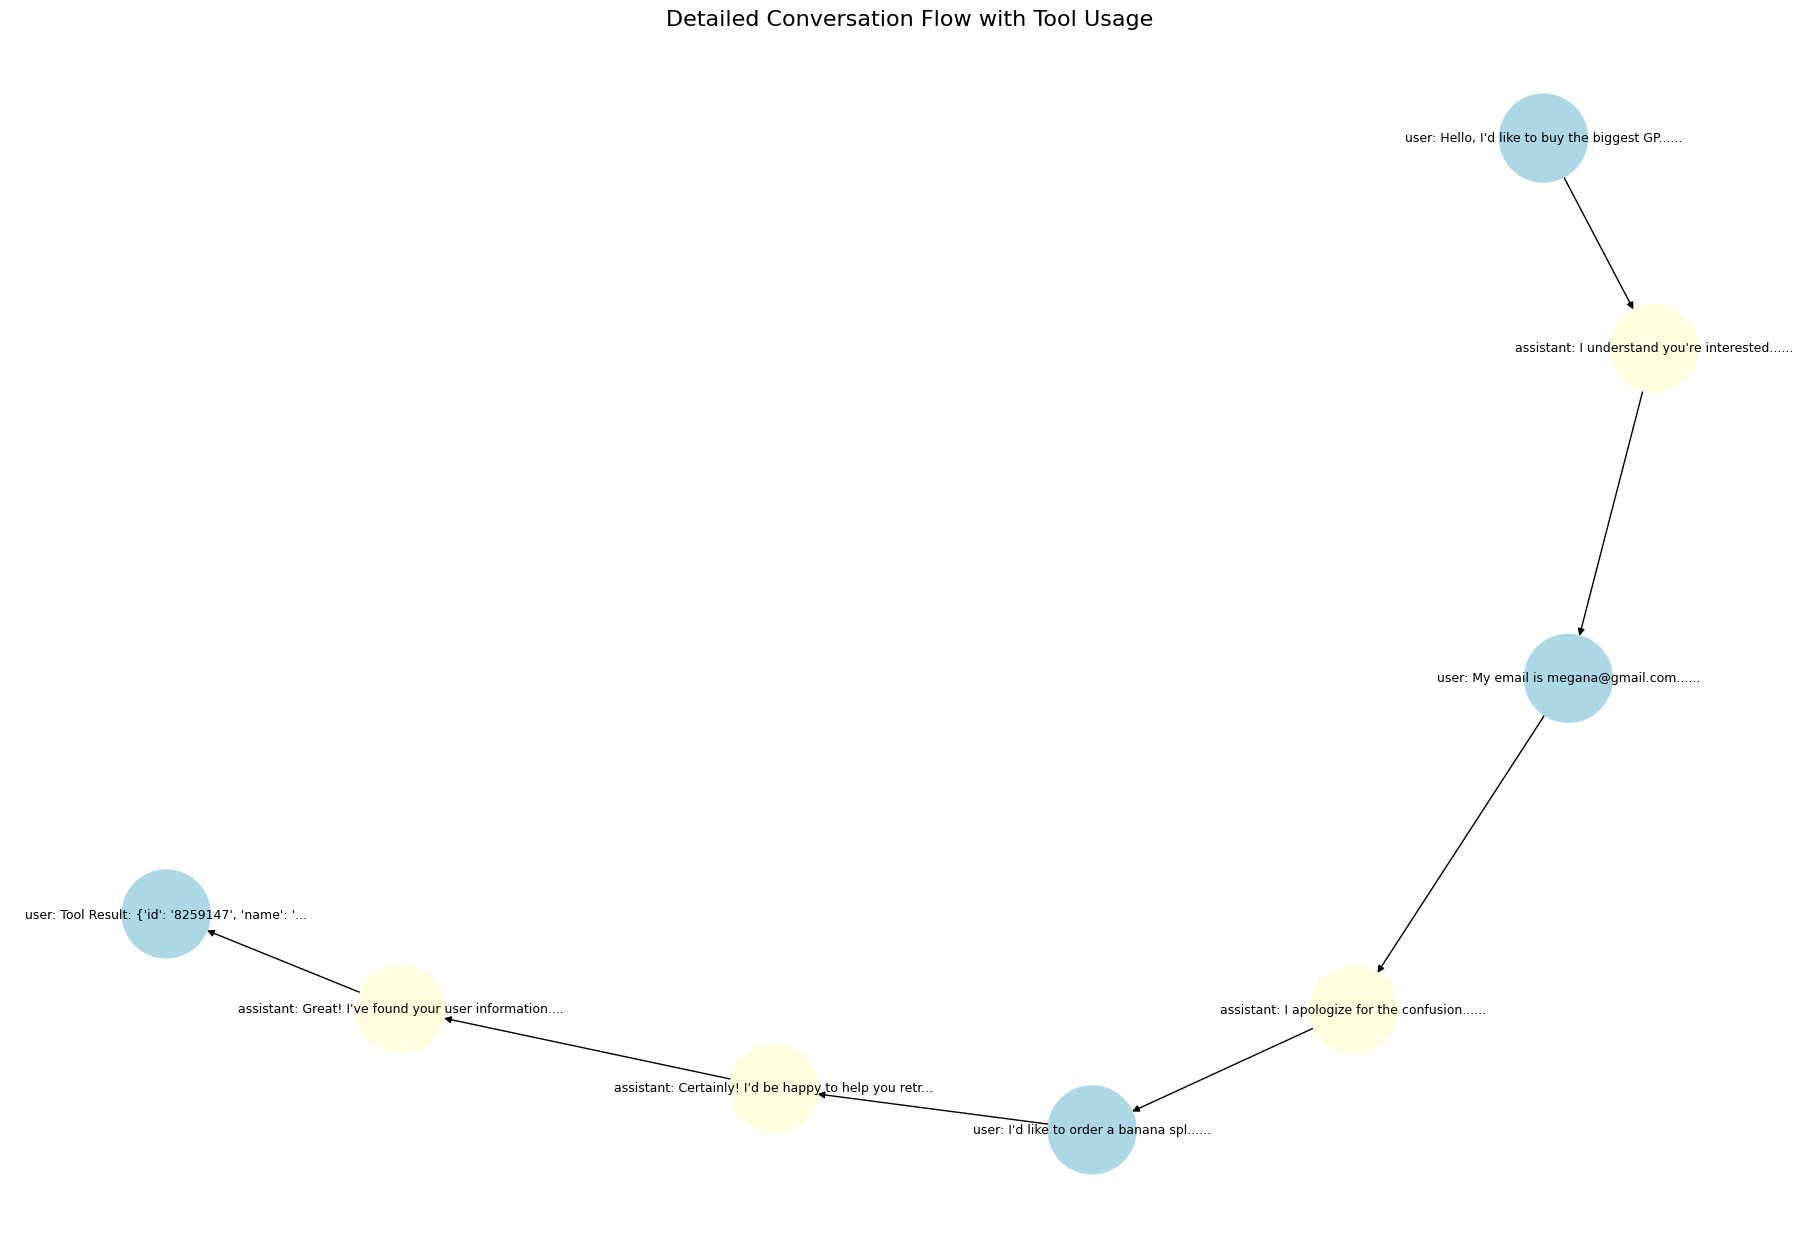

In [16]:
import json
import matplotlib.pyplot as plt
import networkx as nx

# Define the Message class
class Message:
    def __init__(self, role, content):
        self.role = role
        self.content = content

    def __repr__(self):
        return f"Message(role={self.role}, content={self.content})"

# Define the Conversation class
class Conversation:
    def __init__(self, messages=None):
        self.messages = messages if messages is not None else []

    def add_message(self, message):
        self.messages.append(message)

    def get_messages(self):
        return self.messages

    def __repr__(self):
        return f"Conversation(messages={self.messages})"

# Define the function to parse JSON input to a Conversation object
def parse_json_to_conversation(json_input):
    conversation = Conversation()
    for message in json_input['messages']:
        conversation.add_message(Message(message['role'], message['content']))
    return conversation

# Mock function to simulate conversation for testing purposes
def simulate_conversation():
    json_input = {
        "messages": [
            {"role": "user", "content": "Hello, I'd like to buy the biggest GP..."},
            {"role": "assistant", "content": "I understand you're interested..."},
            {"role": "user", "content": "My email is megana@gmail.com..."},
            {"role": "assistant", "content": "I apologize for the confusion..."},
            {"role": "user", "content": "I'd like to order a banana spl..."},
            {"role": "assistant", "content": "Certainly! I'd be happy to help you retrieve your orders. Megana. First, let's use your email to look up your user information, and then we'll fetch your orders.", "type": "text", "ToolUseBlock": {"id": "toolu_01K2G6Pcl1drUB0q7C415VkcR", "input": {"key": "email", "value": "megana@gmail.com"}}},
            {"role": "assistant", "content": "Great! I've found your user information.", "type": "text", "ToolUseBlock": {"id": "toolu_01K2G6Pcl1drUB0q7C415VkfS", "input": {"key": "email", "value": "megana@gmail.com"}}},
            {"role": "user", "content": "Tool Result: {'id': '8259147', 'name': 'Meg..."}
        ]
    }
    return parse_json_to_conversation(json_input)

# Define the detailed graph visualizer function
def detailed_graph_visualizer(conversation):
    """
    Visualize a conversation with detailed graph, including tool usage.

    Parameters:
    conversation (Conversation): The conversation object containing messages.

    Returns:
    None
    """
    G = nx.DiGraph()
    tool_counter = 0
    
    for i, message in enumerate(conversation.get_messages()):
        node_id = f"{i}_{message.role}"
        if message.role == 'user' and isinstance(message.content, list) and message.content[0]['type'] == 'tool_result':
            label = f"Tool Result: {message.content[0]['content'][:40]}..."
            color = 'lightgreen'
        else:
            label = f"{message.role}: {message.content[:40]}..."
            color = 'lightblue' if message.role == 'user' else 'lightyellow'
        
        G.add_node(node_id, label=label, color=color)
        
        if i > 0:
            prev_node_id = f"{i-1}_{conversation.get_messages()[i-1].role}"
            G.add_edge(prev_node_id, node_id)
        
        if message.role == 'assistant' and isinstance(message.content, list):
            for content in message.content:
                if isinstance(content, dict) and content.get('type') == 'tool_use':
                    tool_node_id = f"tool_{tool_counter}"
                    G.add_node(tool_node_id, label=f"Tool: {content['name'][:40]}...", color='lightcoral')
                    G.add_edge(node_id, tool_node_id)
                    tool_counter += 1
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(18, 12))
    
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw(G, pos, with_labels=False, node_color=node_colors, 
            node_size=4000, font_size=10, arrows=True)
    
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    
    plt.title("Detailed Conversation Flow with Tool Usage", fontsize=16)
    plt.axis('off')
    plt.show()

# Re-run the updated visualization function
final_conversation = simulate_conversation()
detailed_graph_visualizer(final_conversation)
